# Цель исследования
Автоматизировать процесс сопоставления побочных эффектов из реальных медицинских текстов с формализованными медицинскими концептами (CUI), используя методы обработки естественного языка (NLP) и векторные представления слов (эмбеддинги), чтобы:

выявить закономерности в лабораторных анализах пациентов с показаниями к антибиотикотерапии;

провести семантическое сопоставление побочных эффектов с терминами медицинской онтологии (UMLS).

In [ ]:
# 1. Установи совместимую версию numpy и scipy (с gensim, spacy, tensorflow)
!pip install numpy==1.26.4 scipy==1.15.1 --force-reinstall --no-cache-dir

# 2. Переустанови gensim и spacy (чтобы пересобрались под текущую numpy)
!pip install --force-reinstall --no-cache-dir gensim spacy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 328.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.6/40.6 MB 330.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# скачать, если не установлено
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_core_sci_lg-0.5.1.tar.gz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.3/532.3 MB 1.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 77.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 88.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 917.4/917.4 kB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 129.5 MB/s eta 0:00:00
  Created wheel for en_core_sci_lg: filename=en_core_sci_lg-0.5.1-py3-none-any.whl size=532571848 sha256=6623ce44585c97743d3420c86940400fddb39301e7748e8955ffe32d89cd7c43
  Stored in directory: /root/.cache/pip/wheels/35/7e/2a/bd14c7

In [2]:
# Импорт библиотеки pandas для работы с таблицами (DataFrame)
import pandas as pd

# Импорт библиотеки numpy для работы с массивами и математикой
import numpy as np

# Импорт статистических функций из scipy
from scipy import stats

# Импорт библиотеки matplotlib для построения графиков
import matplotlib.pyplot as plt

# Импорт статистических тестов из scipy.stats
from scipy.stats import mannwhitneyu, ttest_ind, kruskal, chisquare, pearsonr, spearmanr

# Импорт модуля предобработки из scikit-learn
from sklearn import preprocessing

# Импорт функции для стандартизации данных (StandardScaler)
from sklearn.preprocessing import StandardScaler

# Импорт функции для разделения выборки на обучающую и тестовую (train_test_split)
from sklearn.model_selection import train_test_split

# Импорт библиотеки seaborn для построения визуализаций (на базе matplotlib)
import seaborn as sns

# Импорт регулярных выражений (поиск и замена текста по шаблонам)
import re

# Импорт библиотеки time (работа со временем: замеры, паузы)
import time

# Импорт библиотеки spacy — для обработки естественного языка (NLP)
import spacy

# Импорт библиотеки gensim — для работы с моделями Word2Vec и текстами
import gensim

# Импорт модели KeyedVectors из gensim для загрузки предобученных word2vec моделей
from gensim.models import KeyedVectors

# Импорт функции cosine_similarity — для расчета косинусного сходства между векторами
from sklearn.metrics.pairwise import cosine_similarity

# Импорт модуля warnings и отключение предупреждений
import warnings
warnings.filterwarnings('ignore')  # отключает все предупреждения при выполнении кода


In [3]:
df = pd.read_csv('/content/final_ab_ds.csv', index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54976 entries, 933614 to 999842
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   person_id       54976 non-null  int64  
 1   procalcitonine  54976 non-null  float64
 2   fibrinogen      42093 non-null  float64
 3   creatinine      54967 non-null  float64
 4   wbc             54970 non-null  float64
 5   hb              54970 non-null  float64
 6   plt             54957 non-null  float64
 7   crp             54930 non-null  float64
 8   esr             46623 non-null  float64
 9   lymph           54928 non-null  float64
 10  pneumonia       54976 non-null  int64  
 11  ihd             54976 non-null  int64  
 12  dm              54976 non-null  int64  
 13  ah              54976 non-null  int64  
 14  sex             54976 non-null  int64  
 15  len             54976 non-null  int64  
 16  age             54976 non-null  int64  
 17  GFR             54967 non-null

In [4]:
df = df.dropna()

Отметим, что данные несбалансированы

In [5]:
# Считаем количество примеров с каждым значением в столбце 'ab_indication'
# np.bincount — функция, которая считает, сколько раз встречается каждое целое число в массиве
# df['ab_indication'] — выборка значений из столбца 'ab_indication' таблицы df
# Результат — массив: [кол-во_нулей, кол-во_единиц]
neg, pos = np.bincount(df['ab_indication'])

# Считаем общее количество примеров (негативных и позитивных вместе)
total = neg + pos

# Печатаем информацию:
# - всего примеров
# - сколько из них положительных (1)
# - доля положительных в процентах с 1 знаком после запятой
# .format(...) — подставляет значения в строку с фигурными скобками {}
print('Examples:\n    Total: {}\n    Positive: {} ({:.1f}% of total)\n'.format(
    total, pos, 100 * pos / total))


Examples:
    Total: 35680
    Positive: 8873 (24.9% of total)



<Axes: >

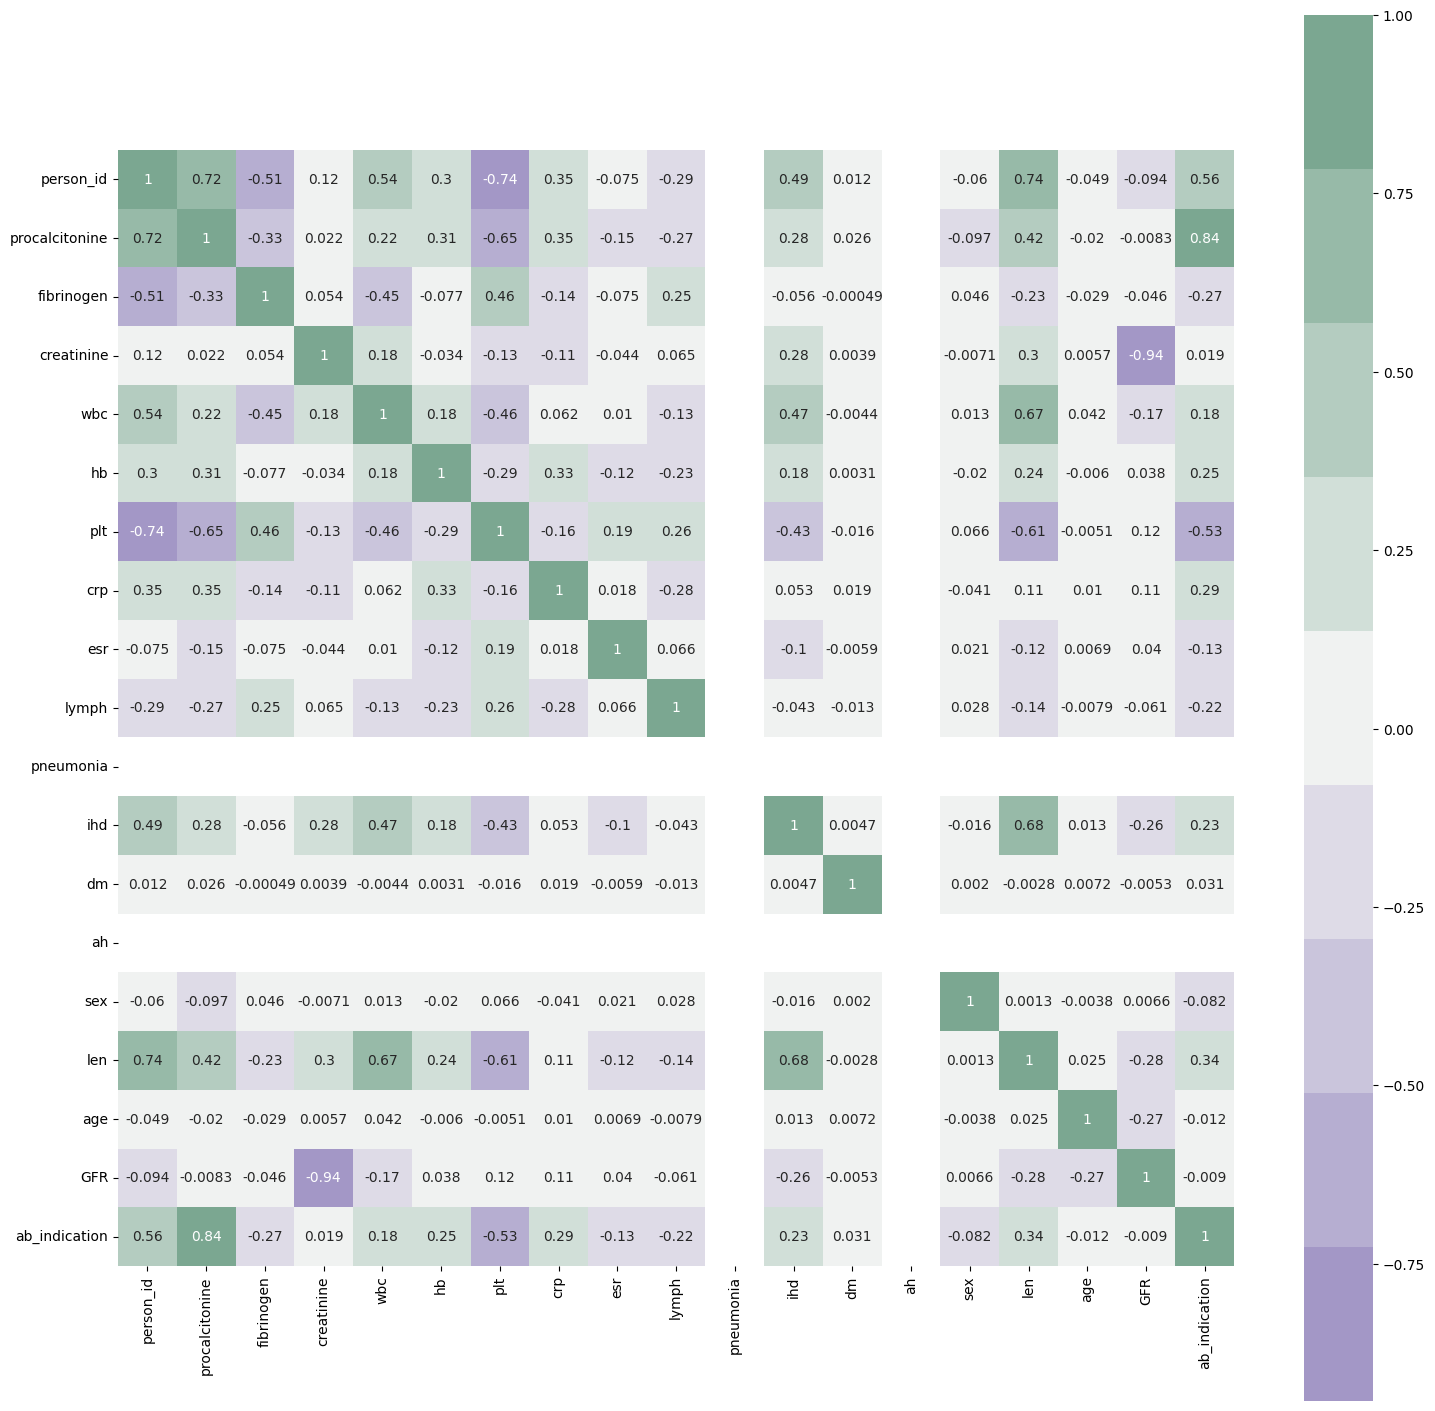

In [6]:
# Создаём цветовую палитру для графика
# sns.diverging_palette(...) — функция из библиотеки seaborn, которая создаёт палитру с плавным переходом между цветами
# 275 и 150 — углы оттенков (например, синий и красный)
# s=40 — насыщенность цвета (saturation)
# l=65 — яркость (lightness)
# n=9 — количество разных цветов в палитре
cmap = sns.diverging_palette(275, 150, s=40, l=65, n=9)

# Строим матрицу корреляций для всех числовых столбцов в таблице df
# df.corr() — вычисляет коэффициенты корреляции между всеми парами числовых признаков
# Результат — квадратная таблица (матрица), где значения от -1 до 1 показывают силу и направление связи
corrmat = df.corr()

# Задаём размер всего графика
# plt.subplots(figsize=(18, 18)) — устанавливает ширину и высоту графика в дюймах (18 на 18)
plt.subplots(figsize=(18, 18))

# Строим тепловую карту на основе корреляционной матрицы
# sns.heatmap(...) — функция построения тепловой карты
# corrmat — данные для отображения (матрица корреляций)
# cmap=cmap — цветовая палитра для отображения значений
# annot=True — включаем отображение чисел в ячейках
# square=True — ячейки будут квадратными (одинаковая ширина и высота)
sns.heatmap(corrmat, cmap=cmap, annot=True, square=True)


In [ ]:
# Создаём список с названиями столбцов, которые нас интересуют
# В этом списке: показатели анализов крови — тромбоциты (plt), СОЭ (esr), фибриноген, креатинин, лейкоциты (wbc), С-реактивный белок (crp), лимфоциты (lymph)
columns = ['plt', 'esr', 'fibrinogen', 'creatinine', 'wbc', 'crp', 'lymph']

# Создаём новую таблицу df_no_ind — только с теми строками, где значение в столбце 'ab_indication' равно 0
# Это пациенты, которым не показаны антибиотики
df_no_ind = df[df['ab_indication'] == 0]

# Создаём таблицу df_ind — только строки, где значение 'ab_indication' равно 1
# Это пациенты, которым показаны антибиотики
df_ind = df[df['ab_indication'] == 1]


In [ ]:
df_no_ind

,person_id,procalcitonine,fibrinogen,creatinine,wbc,hb,plt,crp,esr,lymph,pneumonia,ihd,dm,ah,sex,len,age,GFR,ab_indication
3822,158,0.000000,8.909846,1.030282,1.363834,143.647123,644.437365,58.343027,34.424705,23.300684,1,0,0,0,1,17,56,60.894798,0
915492,342,0.000000,7.092240,1.027174,25.710224,130.864644,483.261016,0.800000,25.493102,27.004637,1,0,0,0,1,34,56,61.117621,0
641908,108,0.134918,13.265546,0.707201,0.410000,141.945473,477.671705,7.526411,46.599795,17.167563,1,0,0,0,1,26,56,95.972393,0
89879,108,0.000000,15.336425,1.094880,12.546527,120.607466,704.633325,27.180197,35.411333,15.268175,1,0,0,0,1,28,56,56.578279,0
744110,980,0.324985,9.899282,1.265045,7.001120,125.988145,166.613698,0.800000,27.280940,12.404405,1,1,0,0,1,33,48,50.257856,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
718264,706,0.112622,11.122910,0.954530,13.101311,141.795781,374.247891,21.111733,19.814036,12.839993,1,1,0,0,1,42,56,66.784947,0
556216,1103,0.199631,7.135134,1.099085,36.772744,137.856675,178.047896,48.956390,17.813114,0.010000,1,0,0,0,1,39,35,65.268376,0
144924,1013,0.335003,4.822600,0.905691,19.587708,136.475023,261.638296,115.226867,41.099277,10.731909,1,0,0,0,1,28,35,82.474743,0
818312,1103,0.125672,2.440000,0.957168,39.037341,163.876818,161.291325,127.079600,22.661706,13.759877,1,1,0,0,1,52,26,82.177240,0


In [ ]:
# Создаём список названий столбцов с лабораторными показателями
columns = ['plt', 'esr', 'fibrinogen', 'creatinine', 'wbc', 'crp', 'lymph']

# Начинаем цикл: проходим по каждому столбцу из списка columns
for i in columns:

  # Извлекаем значения показателя i для группы без антибиотиков
  lst1 = df_no_ind[i]

  # Извлекаем значения показателя i для группы с антибиотиками
  lst2 = df_ind[i]

  # Применяем тест Шапиро-Уилка к lst1 (проверка на нормальность распределения)
  shapiro_test = stats.shapiro(lst1)

  # Применяем тест Шапиро-Уилка к lst2 (для второй группы)
  shapiro_test2 = stats.shapiro(lst2)

  # Если p-значение меньше 0.05 (значит распределение отличается от нормального) — печатаем сообщение
  if shapiro_test[1] < .05:
    print('Данные {0} распределены ненормально,\
           p-value - {1}'.format(i,  shapiro_test[1]))

  # Проверка второго набора (вторая группа)
  if shapiro_test2[1] < .05:
    print('Данные {0} распределены ненормально,\
           p-value - {1}'.format(i,  shapiro_test2[1]))

  # Если оба p-значения >= 0.05, ничего не выводим (всё нормально)
  else:
    pass


Данные plt распределены ненормально,           p-value - 1.5900588566632336e-20
Данные plt распределены ненормально,           p-value - 7.237914522152905e-47
Данные esr распределены ненормально,           p-value - 1.1770723532313181e-40
Данные esr распределены ненормально,           p-value - 1.392579617834783e-30
Данные fibrinogen распределены ненормально,           p-value - 9.052275578863804e-20
Данные fibrinogen распределены ненормально,           p-value - 4.40147617694549e-27
Данные creatinine распределены ненормально,           p-value - 1.8625010377532536e-23
Данные creatinine распределены ненормально,           p-value - 3.273536824833956e-13
Данные wbc распределены ненормально,           p-value - 2.6084998117038834e-60
Данные wbc распределены ненормально,           p-value - 9.905119130316824e-29
Данные crp распределены ненормально,           p-value - 2.4787564163861844e-80
Данные crp распределены ненормально,           p-value - 9.303236947157292e-34
Данные lymph распред

p-value ниже 0.05, т.о мы  отвергаем нулевую гипотезу о нормальности распределения и будем работать с данными используя непараметрические стат.методы

In [ ]:
# Определяем функцию Basic_statistics, которая принимает два списка чисел: lst_1 и lst_2
# Эта функция будет применять два статистических теста и возвращать их p-value
def Basic_statistics(lst_1, lst_2):
    """
    Функция "Базовые статистики"

    На вход получает 2 списка данных для сравнения.
    На выходе получаем p-values, при сравнении признаков.
    В частности: показаны, не показаны антибиотики
    """

    # Применяем непараметрический тест Крускала-Уоллиса (для сравнения распределений в двух группах)
    # kruskal — функция из scipy.stats
    # Возвращает статистику и p-value, здесь берём p-value через [1]
    res_kw = kruskal(lst_1, lst_2)  # Краскела-Уоллиса

    # Применяем тест ANOVA (анализ дисперсии) — сравнивает средние значения двух групп
    # f_oneway — функция из scipy.stats
    # Возвращает статистику и p-value, здесь берём p-value через [1]
    anova = stats.f_oneway(lst_1, lst_2)  # тест ANOVA

    # Возвращаем оба p-value — сначала от Крускала-Уоллиса, затем от ANOVA
    return res_kw[1], anova[1]


In [ ]:

# Начинаем цикл по каждому названию столбца из списка columns
for col in columns:

  # Извлекаем значения признака col для группы без антибиотиков
  lst1 = df_no_ind[col]

  # Извлекаем значения признака col для группы с антибиотиками
  lst2 = df_ind[col]

  # Вызываем функцию Basic_statistics для lst1 и lst2, сохраняем p-value Крускала-Уоллиса в переменную kw
  kw = Basic_statistics(lst1, lst2)[0]

  # То же самое — получаем p-value теста ANOVA, сохраняем в переменную an
  an = Basic_statistics(lst1, lst2)[1]

  # Если p-value Крускала-Уоллиса меньше 0.05 (значимые различия) — выводим сообщение
  if kw < .05:
    print('Данные {0} статисически значимо различаются в подгруппах,\
           p-value - {1}, тест Крускала-Уоллиса'.format(col,  kw))

  # Если p-value ANOVA меньше 0.05 — тоже выводим сообщение
  if an < .05:
    print('Данные {0} статисически значимо различаются в подгруппах,\
           p-value - {1}, тест Анова'.format(col,  an))

  # Если ни одно условие не выполнено — ничего не делаем
  else:
    pass


Данные plt статисически значимо различаются в подгруппах,           p-value - 0.0, тест Крускала-Уоллиса
Данные plt статисически значимо различаются в подгруппах,           p-value - 0.0, тест Анова
Данные esr статисически значимо различаются в подгруппах,           p-value - 2.7536251235414657e-121, тест Крускала-Уоллиса
Данные esr статисически значимо различаются в подгруппах,           p-value - 2.1921373115857108e-126, тест Анова
Данные fibrinogen статисически значимо различаются в подгруппах,           p-value - 0.0, тест Крускала-Уоллиса
Данные fibrinogen статисически значимо различаются в подгруппах,           p-value - 0.0, тест Анова
Данные creatinine статисически значимо различаются в подгруппах,           p-value - 0.003026493786471801, тест Крускала-Уоллиса
Данные creatinine статисически значимо различаются в подгруппах,           p-value - 0.0003838304871477176, тест Анова
Данные wbc статисически значимо различаются в подгруппах,           p-value - 9.49496142847372e-224, 

#### Выводы:


- 1.   В подгруппах есть  статистически значимые различия
- 2.   На данном этапе есть оснований полагать, что есть некая закономерность в анализах у пациентов с показаниями к антибиотикотерапии

In [ ]:
# Отделяем признаки (X) от целевой переменной (Y)

# df.drop('ab_indication', axis=1) — удаляем столбец 'ab_indication' из таблицы df
# axis=1 — означает, что удаляется столбец, а не строка
# Результат сохраняется в переменную X — это будут входные данные (признаки)
X = df.drop('ab_indication', axis=1)

# df['ab_indication'] — извлекаем столбец 'ab_indication' как целевую переменную
# Сохраняем результат в переменную Y
Y = df['ab_indication']

# Разбиваем данные на обучающую и тестовую выборки с помощью функции train_test_split

# X, Y — входные и выходные данные
# test_size = 0.20 — 20% данных отводим под тестовую выборку
# stratify = Y — сохраняем пропорции классов в обучающей и тестовой выборках
# random_state = 42 — фиксируем случайность (чтобы каждый раз разбиение было одинаковым)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size=0.20,
                                                    stratify=Y,
                                                    random_state=42)

# Повторно разбиваем обучающую выборку: выделяем из неё валидационную часть

# X_train, Y_train — текущие обучающие данные
# test_size = 0.20 — теперь 20% от оставшихся обучающих данных будет валидацией
# stratify = Y_train — сохраняем пропорции классов
# random_state = 42 — сохраняем одинаковое разбиение
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train,
                                                  test_size=0.20,
                                                  stratify=Y_train,
                                                  random_state=42)


# ЗАДАНИЕ
**Этап построения модели машинного обучения**

---
Стандартные шаги перед обучением (стандартизация/нормализаця), решение необходомости ресамплинга из-за дисбаланса данных, выбор параметров модели и бизнесс логика.


# Бизнес логика


У департамента RWD фарм.компаниии, стояла задача предоставить для команды рекламщиков решения, для улучшения дистрибьюции препаратов.

Этот запрос был делегирован нашей DS команде для формулировки идей / подходов.
Выдвинутая гипотеза в предельно простом виде звучала следующим образом:  
*можем ли мы предсказать будущих пользователей на основе клинических и других признаков пациентов?*

После проведения подготовительных мероприятий: построение датасета, модели, анализа метрик.
Оказалось, что модель обладает хорошей чувствительностью, однако, низкой специфичностью, а целевые метрики были субоптимальными.
Тогда возникла идея, трансформировать слабые стороны модели в преимущества и выдвинуть гипотезу 2: мы допускаем, что пациенты, имеющие ложноположительное предсказание могут иметь более высокую предрасположенность к тому, чтобы быть пользователями препарата, поэтому эта субпопуляция может являться таргетной группой для дополнительных маркетинговых воздействий.

Идея изложена в предельно незавуалированном виде, но она очень понравилась заказчику и теперь модель используется в продакшне.


# Пример решения NLP задачи из реальной практики (прототип)
---
Ранее мы использовали инструменты и подходы NLP для решения задач нашего локального исследования.
> В задании №3, вы столкнулись с проблемой обозначения побочных эффектов в избранной онтологической системе.

Взглянем на вариант решения задачи, используя мощную библиотеку gensim, которая предоставляет возможность "word embeddings".

In [ ]:
# Читаем CSV-файл с названием 'to_find' и сохраняем его в переменную adverse_effects
# pd.read_csv — функция чтения таблицы из CSV-файла (из библиотеки pandas)
# 'to_find' — имя файла, который читаем
# sep = '|' — указываем, что в файле данные разделены символом "|"
adverse_effects = pd.read_csv('to_find', sep='|')

# Читаем второй файл с названием 'концепты.tsv' и сохраняем его в переменную CUIs
# 'концепты.tsv' — имя второго файла
# sep = '\t' — указываем, что данные разделены табуляцией (файл в формате .tsv)
CUIs = pd.read_csv('концепты.tsv', sep='\t')

# Показываем первые 5 строк таблицы adverse_effects
# .head() — метод pandas, который возвращает первые 5 строк таблицы по умолчанию
adverse_effects.head()


,id,Text
0,22,The vertigo is rendering me unable to function...
1,23,I am seeing a specialist for the vertigo and u...
2,24,My vertigo has not responded to conservative t...
3,25,"Muscle spasms, muscle twitching, muscle sorene..."
4,26,I took Lexapro for 3 days in 10mg doses and ha...


In [ ]:
CUIs.head()

,CUI,CONCEPT,SNOMED_CODE
0,C0000765,"Excessive body weight gain,Excessive weight gain",224994002
1,C0701811,"Poor short-term memory,Poor short-term memory",247592009
2,C0002170,"Alopecia,Loss of hair",278040002
3,C0549622,"Sexual Dysfunction,Sexual disorder",231532002
4,C0027497,"Nausea,Nausea",422587007


In [ ]:
# Загружаем предобученную модель spaCy для обработки научного английского языка

# spacy.load — функция из библиотеки spaCy, которая загружает языковую модель
# "en_core_sci_lg" — имя модели:
#   en        — английский язык
#   core      — базовая лингвистическая модель
#   sci       — специализирована для научных (biomedical) текстов
#   lg        — large (большой размер, высокая точность)

# Результат сохраняем в переменную nlp — она будет использоваться для обработки текста
nlp = spacy.load("en_core_sci_lg")


In [ ]:
# Создаём список стоп-слов — слов, которые нужно игнорировать или удалить
# Эти слова не несут полезной смысловой нагрузки (например, служебные обозначения)
stop_words = ['noc', 'nos', '[d]', 'unknown_unit', '|', 'see comment', 'due', 'nec', 'unspecified', '[v]', '(see comments)']

# Обрабатываем текст в столбце 'Text' таблицы adverse_effects
# .apply(...) — применяет функцию к каждому значению в столбце
# lambda x: ... — анонимная функция (однострочная)
# isinstance(x, str) — проверяет, является ли значение строкой

# str(x).encode('ascii', 'ignore').decode() — удаляет все не-ASCII символы
# re.sub(r"\s+", " ", ...) — заменяет любые повторяющиеся пробелы и табуляции одним пробелом
# Результат записывается в новый столбец 'adv_name_processed'
adverse_effects['adv_name_processed'] = adverse_effects['Text'].apply(
    lambda x: re.sub(r"\s+", " ", str(x).encode('ascii', 'ignore').decode()) if isinstance(x, str) else str(x)
)

# Обрабатываем текст в столбце 'CONCEPT' таблицы CUIs аналогично
# encode('ascii', 'ignore') — удаляет символы, не входящие в ASCII
# decode() — превращает байты обратно в строку
# re.sub(r"\s+", " ", ...) — убирает лишние пробелы
# Результат сохраняется в новый столбец 'concept_name_processed'
CUIs['concept_name_processed'] = CUIs['CONCEPT'].apply(
    lambda x: re.sub(r"\s+", " ", str(x.encode('ascii', 'ignore').decode()))
)


In [ ]:
# Удаляем знаки препинания и специальные символы из текста в столбце 'adv_name_processed' таблицы adverse_effects

# .map(...) — применяет функцию к каждому элементу столбца
# lambda x: ... — анонимная функция
# re.sub('[,\.!;?)%(\'\":\-]', '', x) — заменяет все указанные символы на пустую строку (удаляет их)
# В квадратных скобках перечислены символы: , . ! ; ? ) % ( ' " : -
# Результат сохраняется обратно в тот же столбец
adverse_effects['adv_name_processed'] = adverse_effects['adv_name_processed'].map(
    lambda x: re.sub('[,\.!;?)%(\'\":\-]', '', x)
)

# То же самое проделываем со столбцом 'concept_name_processed' в таблице CUIs
CUIs['concept_name_processed'] = CUIs['concept_name_processed'].map(
    lambda x: re.sub('[,\.!;?)%(\'\":\-]', '', x)
)


In [ ]:
# Преобразуем текст в столбце 'adv_name_processed' таблицы adverse_effects к нижнему регистру

# .map(...) — применяет функцию к каждому элементу столбца
# lambda x: x.lower() — функция, которая переводит строку x в нижний регистр
# lower() — встроенный метод строк, преобразует все заглавные буквы в строчные
# Результат сохраняется обратно в столбец 'adv_name_processed'
adverse_effects['adv_name_processed'] = adverse_effects['adv_name_processed'].map(
    lambda x: x.lower()
)

# То же самое делаем со столбцом 'concept_name_processed' таблицы CUIs
CUIs['concept_name_processed'] = CUIs['concept_name_processed'].map(
    lambda x: x.lower()
)


In [ ]:
# Удаляем стоп-слова из текста в столбце 'adv_name_processed' таблицы adverse_effects

# .apply(...) — применяет функцию к каждому элементу столбца
# lambda x: ... — анонимная функция для обработки строки
# x.split() — разбивает строку на отдельные слова по пробелам
# [word for word in x.split() if word not in (stop_words)] — создаёт новый список слов без стоп-слов
# ' '.join(...) — объединяет слова обратно в строку через пробел
# stop_words — заранее заданный список слов, которые нужно удалить
adverse_effects['adv_name_processed'] = adverse_effects['adv_name_processed'].apply(
    lambda x: ' '.join([word for word in x.split() if word not in (stop_words)])
)

# То же самое делаем со столбцом 'concept_name_processed' в таблице CUIs
CUIs['concept_name_processed'] = CUIs['concept_name_processed'].apply(
    lambda x: ' '.join([word for word in x.split() if word not in (stop_words)])
)


In [ ]:
# Определяем функцию tokenize, которая принимает на вход строку текста

def tokenize(text):

    # Обрабатываем текст с помощью модели spaCy
    # nlp(text) — разбивает текст на токены, делает лемматизацию, удаляет знаки препинания и т.д.
    doc = nlp(text)

    # Формируем список токенов (слов) из документа doc
    # token.text — сам текст токена (например, слово)
    # if not token.is_punct — исключаем токены, которые являются знаками препинания
    # if not token.is_space — исключаем токены, которые являются пробелами
    tokens = [token.text for token in doc if not token.is_punct and not token.is_space]

    # Возвращаем полученный список токенов
    return tokens


In [ ]:
# Засекаем время начала выполнения кода
# time.time() — возвращает текущее время в секундах с начала эпохи (обычно с 1970 года)
# Результат сохраняется в переменную start_time
start_time = time.time()

# Применяем функцию tokenize ко всем строкам в столбце 'adv_name_processed' таблицы adverse_effects
# .apply(tokenize) — вызывает функцию tokenize для каждой строки
# Функция вернёт список токенов (слов), очищенных от пунктуации и пробелов
# Результат сохраняется обратно в столбец 'adv_name_processed'
adverse_effects['adv_name_processed'] = adverse_effects['adv_name_processed'].apply(tokenize)

# То же самое проделываем для столбца 'concept_name_processed' в таблице CUIs
CUIs['concept_name_processed'] = CUIs['concept_name_processed'].apply(tokenize)

# Вычисляем, сколько времени заняло выполнение
# time.time() - start_time — разница между текущим временем и временем старта
# Делим на 60 — переводим секунды в минуты
elapsed_time = (time.time() - start_time)/60

# Выводим сообщение с округлением до одного знака после запятой
# f"...{elapsed_time:.1f}..." — форматированная строка, вставляет число с одним знаком после запятой
print(f"Затраченное время: {elapsed_time:.1f} секунд(ы)")


Затраченное время: 0.0 секунд(ы)


In [ ]:
# Определяем функцию lemmatize, которая принимает на вход строку текста

def lemmatize(text):

    # Обрабатываем текст с помощью модели spaCy
    # nlp(text) — превращает строку текста в объект doc, содержащий токены и их свойства
    doc = nlp(text)

    # Создаём список лемм (начальных форм слов) для каждого токена в тексте
    # token.lemma_ — лемма токена (например, для "running" это "run")
    lemmatized_tokens = [token.lemma_ for token in doc]

    # Возвращаем список лемматизированных токенов
    return lemmatized_tokens


In [ ]:
# Засекаем время начала выполнения
# time.time() — возвращает текущее время в секундах с начала эпохи
start_time = time.time()

# Обрабатываем столбец 'adv_name_processed' в таблице adverse_effects
# .apply(...) — применяет функцию к каждому значению в столбце
# lambda x: lemmatize(' '.join(x)) — объединяет список слов в строку через пробел, затем передаёт её в функцию lemmatize
# ' '.join(x) — превращает список токенов в одну строку, разделённую пробелами
# lemmatize(...) — возвращает список лемм (начальных форм слов)
# Результат сохраняется обратно в столбец
adverse_effects['adv_name_processed'] = adverse_effects['adv_name_processed'].apply(
    lambda x: lemmatize(' '.join(x))
)

# То же самое выполняется для столбца 'concept_name_processed' в таблице CUIs
CUIs['concept_name_processed'] = CUIs['concept_name_processed'].apply(
    lambda x: lemmatize(' '.join(x))
)

# Вычисляем общее время выполнения
# time.time() - start_time — разница между текущим временем и стартовым
# Делим на 60 — получаем минуты
elapsed_time = (time.time() - start_time)/60

# Выводим затраченное время с округлением до одного знака после запятой
print(f"Затраченное время: {elapsed_time:.1f} секунд(ы)")


Затраченное время: 0.0 секунд(ы)


In [ ]:
adverse_effects.head(10)

,id,Text,adv_name_processed
0,22,The vertigo is rendering me unable to function...,"[the, vertigo, be, render, I, unable, to, func..."
1,23,I am seeing a specialist for the vertigo and u...,"[I, be, see, a, specialist, for, the, vertigo,..."
2,24,My vertigo has not responded to conservative t...,"[my, vertigo, have, not, respond, to, conserva..."
3,25,"Muscle spasms, muscle twitching, muscle sorene...","[muscle, spasm, muscle, twitching, muscle, sor..."
4,26,I took Lexapro for 3 days in 10mg doses and ha...,"[I, take, lexapro, for, 3, day, in, 10, mg, do..."
5,27,Im sorry this is more about not taking it than...,"[I, m, sorry, this, be, more, about, not, take..."
6,30,Extreme Weight Gain 30 pounds.,"[extreme, weight, gain, 30, pound]"
7,31,"Excessive perspiration, Erectile dysfunction.","[excessive, perspiration, erectile, dysfunction]"
8,32,"Almost no libido at all, Utterly useless.","[almost, no, libido, at, all, utterly, useless]"
9,33,Took a while to have an effect on mood obvious...,"[take, a, while, to, have, an, effect, on, moo..."


In [ ]:
CUIs.head(10)

,CUI,CONCEPT,SNOMED_CODE,concept_name_processed
0,C0000765,"Excessive body weight gain,Excessive weight gain",224994002,"[excessive, body, weight, gainexcessive, weigh..."
1,C0701811,"Poor short-term memory,Poor short-term memory",247592009,"[poor, shortterm, memorypoor, shortterm, memory]"
2,C0002170,"Alopecia,Loss of hair",278040002,"[alopecialoss, of, hair]"
3,C0549622,"Sexual Dysfunction,Sexual disorder",231532002,"[sexual, dysfunctionsexual, disorder]"
4,C0027497,"Nausea,Nausea",422587007,[nauseanausea]
5,C0344232,"Blurred vision,Blurring of visual image",111516008,"[blurred, visionblurring, of, visual, image]"
6,C0037316,"Sleep Deprivation,Sleep deprivation",130989002,"[sleep, deprivationsleep, deprivation]"
7,C0424000,"Feeling suicidal,Feeling suicidal",225457007,"[feel, suicidalfeele, suicidal]"
8,C0424565,"Cannot sleep at all,Cannot sleep at all",248255005,"[can, not, sleep, at, allcannot, sleep, at, all]"
9,C1971624,"Loss of appetite,Loss of appetite",79890006,"[loss, of, appetiteloss, of, appetite]"


In [ ]:
# Сортируем токены (слова) в каждом списке в столбце 'adv_name_processed' таблицы adverse_effects

# .apply(...) — применяет функцию к каждому элементу столбца
# lambda x: sorted(x) — сортирует список x в алфавитном порядке
# sorted(x) — встроенная функция Python, возвращает отсортированный список
# Результат сохраняется обратно в столбец 'adv_name_processed'
adverse_effects['adv_name_processed'] = adverse_effects['adv_name_processed'].apply(
    lambda x: sorted(x)
)

# То же самое делаем для столбца 'concept_name_processed' таблицы CUIs
CUIs['concept_name_processed'] = CUIs['concept_name_processed'].apply(
    lambda x: sorted(x)
)


In [ ]:
# Команда для загрузки файла из интернета с помощью утилиты wget

# !wget — команда оболочки Linux, используется в Jupyter Notebook для скачивания файлов
# https://ftp.ncbi.nlm.nih.gov/pub/lu/Suppl/BioSentVec/BioWordVec_PubMed_MIMICIII_d200.vec.bin — ссылка на файл
# -P data/ — опция, указывающая папку назначения для сохранения файла ("data/" — подкаталог в текущей директории)
!wget https://ftp.ncbi.nlm.nih.gov/pub/lu/Suppl/BioSentVec/BioWordVec_PubMed_MIMICIII_d200.vec.bin -P data/



--2025-06-08 06:16:51--  https://ftp.ncbi.nlm.nih.gov/pub/lu/Suppl/BioSentVec/BioWordVec_PubMed_MIMICIII_d200.vec.bin
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.10, 130.14.250.12, 130.14.250.13, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13451441787 (13G) [application/octet-stream]
Saving to: ‘data/BioWordVec_PubMed_MIMICIII_d200.vec.bin’

BioWordVec_PubMed_M 100%[===================>]  12.53G   148MB/s    in 1m 45s  

2025-06-08 06:18:36 (122 MB/s) - ‘data/BioWordVec_PubMed_MIMICIII_d200.vec.bin’ saved [13451441787/13451441787]



In [ ]:
!ls -lh data/BioWordVec_PubMed_MIMICIII_d200.vec.bin


-rw-r--r-- 1 root root 13G Oct 21  2018 data/BioWordVec_PubMed_MIMICIII_d200.vec.bin


In [ ]:
# Указываем путь к файлу модели эмбеддингов
# model_path — переменная, в которую записан путь до файла с предобученной моделью векторов слов
# 'data/BioWordVec_PubMed_MIMICIII_d200.vec.bin' — это файл с обученными векторами слов от NCBI (BioWordVec)
# Файл нужно скачать заранее по ссылке: https://github.com/ncbi-nlp/BioSentVec
model_path = 'data/BioWordVec_PubMed_MIMICIII_d200.vec.bin'

# Загружаем модель word2vec с помощью библиотеки gensim
# gensim.models.KeyedVectors.load_word2vec_format — функция для загрузки модели в формате word2vec
# model_path — путь к файлу модели
# binary=True — указывает, что файл сохранён в бинарном формате (а не текстовом)
# Результат сохраняется в переменную word2vec_model
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format(model_path, binary=True)


In [ ]:
# Определяем функцию vectorize_text_with_gensim_embeddings для преобразования текста в вектор с использованием модели BioWordVec
# text — входная строка текста
# model — предобученная модель word embeddings (например, BioWordVec), загруженная с помощью gensim

def vectorize_text_with_gensim_embeddings(text, model):

    # Разбиваем строку на отдельные слова по пробелам
    # text.split() — возвращает список слов
    tokens = text.split()

    # Создаём список векторов слов, которые есть в модели
    # model[token] — возвращает вектор слова token из модели
    # if token in model — проверяет, что слово есть в словаре модели
    vectors = [model[token] for token in tokens if token in model]

    # Если хотя бы один вектор был найден:
    if vectors:
        # Возвращаем среднее значение всех векторов по строкам (axis=0) — создаётся один объединённый вектор
        return np.mean(vectors, axis=0)
    else:
        # Если не найдено ни одного слова из модели, возвращаем нулевой вектор нужной размерности
        # model.vector_size — размерность векторов в используемой модели
        return np.zeros(model.vector_size)


In [ ]:
# Засекаем время начала выполнения
# time.time() — возвращает текущее время в секундах с начала эпохи
start_time = time.time()

# Задаём количество лучших совпадений, которые хотим отобрать
# num_top_matches = 2 означает, что мы будем искать 2 наиболее похожих вектора
num_top_matches = 2

# Создаём новый столбец 'adv_eff_vector' в таблице adverse_effects

# adverse_effects['adv_name_processed'] — это столбец, содержащий список слов (токенов) для каждого побочного эффекта

# .apply(...) — применяет функцию к каждому значению в этом столбце

# lambda x: ... — анонимная функция, которая будет обрабатывать каждый список слов (x)

# ' '.join(x) — объединяет список слов x в одну строку, вставляя пробелы между словами

# vectorize_text_with_gensim_embeddings(...) — функция, которая преобразует текстовую строку в числовой вектор
# она использует предобученную модель word2vec (word2vec_model) и усредняет векторы слов из текста

# Результат — вектор признаков (например, длиной 200), который сохраняется в ячейку нового столбца 'adv_eff_vector'

adverse_effects['adv_eff_vector'] = adverse_effects['adv_name_processed'].apply(
    lambda x: vectorize_text_with_gensim_embeddings(' '.join(x), word2vec_model)
)


# Преобразуем столбец 'adv_eff_vector' в таблице adverse_effects в одну общую матрицу
# np.vstack(...) — объединяет все векторы в массив вертикально (по строкам)
# Результат сохраняется в переменную v1
v1 = np.vstack(adverse_effects['adv_eff_vector'])

# Создаём новый столбец 'CUI_vector' в таблице CUIs

# CUIs['concept_name_processed'] — это столбец, содержащий список слов (токенов) для каждого медицинского концепта

# .apply(...) — применяет функцию к каждому значению в этом столбце

# lambda x: ... — анонимная функция, которая обрабатывает каждый список слов x

# ' '.join(x) — объединяет список слов x в одну строку, вставляя между ними пробелы

# vectorize_text_with_gensim_embeddings(...) — функция, которая преобразует строку в числовой вектор
# она использует предобученную модель word2vec (word2vec_model) и усредняет векторы всех слов из строки

# Результат — вектор признаков (например, длиной 200), который записывается в новый столбец 'CUI_vector'

CUIs['CUI_vector'] = CUIs['concept_name_processed'].apply(
    lambda x: vectorize_text_with_gensim_embeddings(' '.join(x), word2vec_model)
)


# То же самое выполняем для столбца 'CUI_vector' в таблице CUIs
# Получаем матрицу векторов из концептов
v2 = np.vstack(CUIs['CUI_vector'])

# Вычисляем, сколько времени заняло выполнение
# time.time() - start_time — разница между текущим временем и временем начала
# Делим результат на 60, чтобы перевести секунды в минуты
elapsed_time = (time.time() - start_time) / 60

# Выводим сообщение о затраченном времени, округлённое до одного знака после запятой
# f"...{elapsed_time:.1f}..." — форматированная строка
print(f"Затраченное время: {elapsed_time:.1f} секунд(ы)")


Затраченное время: 0.0 секунд(ы)


#Cемантическое сопоставление с помощью Косинусного сходства

In [ ]:
# Вычисляем матрицу косинусного сходства между всеми парами векторов из v1 и v2
# cosine_similarity(v1, v2) — функция из sklearn, которая вычисляет меру сходства между векторами
# v1 — матрица векторов из adverse_effects
# v2 — матрица векторов из CUIs
# Результат: матрица размером (кол-во_строк_v1 × кол-во_строк_v2), где каждое значение — мера сходства от 0 до 1
similarity = cosine_similarity(v1, v2)

# Получаем индексы top-N (наиболее похожих) строк для каждого вектора из v1
# -similarity — меняем знак, чтобы сортировка по возрастанию давала сначала самые похожие
# argsort() — возвращает индексы, отсортированные по значению
# [:, :num_top_matches] — оставляем только num_top_matches (например, 2) лучших совпадения для каждой строки
tops = (-similarity).argsort()[:, :num_top_matches]

# Собираем итоговую таблицу с совпадениями
# Внешний pd.concat собирает все совпадения в одну таблицу
joined_table = pd.concat(

    # Внутренний pd.concat соединяет:
    # 1. Строку из adverse_effects с полями 'Text' и 'id'
    # 2. Строку из CUIs с полями 'CUI' и 'CONCEPT'
    # 3. Значение сходства (similarity[i][t]) — объединяется в отдельную колонку
    pd.concat(
        [
            # Извлекаем строку с индексом i из adverse_effects и оставляем только 'Text' и 'id'
            # .loc[[i], ...] — выборка строки по индексу
            # .reset_index(drop=True) — сбрасываем индекс, чтобы не мешал при объединении
            adverse_effects.loc[[i], ['Text', 'id']].reset_index(drop=True),

            # Извлекаем строку t из CUIs с колонками 'CUI' и 'CONCEPT'
            CUIs.loc[[t], ['CUI', 'CONCEPT']].reset_index(drop=True),

            # Добавляем значение сходства между строкой i и t
            # pd.Series(...) — создаёт новую колонку 'Similarity' с одним значением
            pd.Series(similarity[i][t], name='Similarity')
        ],
        axis=1  # Объединяем по колонкам
    )

     # Проходим по всем строкам из adverse_effects (индексы i)
     # Для каждой строки берём список подходящих индексов t из tops[i]
     for i in range(0, len(adverse_effects)) for t in tops[i]

).reset_index(drop=True)  # После объединения сбрасываем общий индекс итоговой таблицы

# Вычисляем и выводим, сколько времени заняло выполнение всей операции
elapsed_time = (time.time() - start_time) / 60
print(f"Затраченное время: {elapsed_time:.1f} секунд(ы)")


Затраченное время: 0.2 секунд(ы)


In [ ]:
joined_table.head(30)

,Text,id,CUI,CONCEPT,Similarity
0,The vertigo is rendering me unable to function...,22,C0456820,"Loss of capacity to feel emotions,Loss of capa...",0.909012
1,The vertigo is rendering me unable to function...,22,C0563158,"Compulsion to act on dangerous thoughts,Compul...",0.884145
2,I am seeing a specialist for the vertigo and u...,23,C1562291,Loss of interest in previously enjoyable activ...,0.856806
3,I am seeing a specialist for the vertigo and u...,23,C0456820,"Loss of capacity to feel emotions,Loss of capa...",0.846142
4,My vertigo has not responded to conservative t...,24,C0423994,"Unable to think clearly,Unable to think clearly",0.877083
5,My vertigo has not responded to conservative t...,24,C0456820,"Loss of capacity to feel emotions,Loss of capa...",0.852326
6,"Muscle spasms, muscle twitching, muscle sorene...",25,C0151786,"Muscle Weakness,Muscle weakness",0.867573
7,"Muscle spasms, muscle twitching, muscle sorene...",25,C0151786,"Muscle Weakness,muscle weakness",0.867573
8,I took Lexapro for 3 days in 10mg doses and ha...,26,C0233408,"Disorientated in time,Disorientated in time",0.821447
9,I took Lexapro for 3 days in 10mg doses and ha...,26,C0233408,"Disorientated in time,disorientated in time",0.821447


#Cемантическое сопоставление с помощью Nearest Neighbors (на sklearn)

In [ ]:
# Импортируем класс NearestNeighbors из библиотеки sklearn
# Он используется для поиска ближайших соседей (похожих объектов)
from sklearn.neighbors import NearestNeighbors

# Задаём число ближайших соседей, которых хотим найти
# В нашем случае — 2 наиболее похожих медицинских концепта для каждого побочного эффекта
num_top_matches = 2

# Преобразуем столбец 'adv_eff_vector' (векторы побочных эффектов) в единую матрицу
# np.vstack — объединяет все векторы из столбца в один двумерный массив (матрицу)
v1 = np.vstack(adverse_effects['adv_eff_vector'])

# Преобразуем столбец 'CUI_vector' (векторы медицинских концептов) в единую матрицу
v2 = np.vstack(CUIs['CUI_vector'])

# Создаём модель для поиска ближайших соседей
# n_neighbors = num_top_matches — количество ближайших соседей, которое нужно найти
# metric = 'cosine' — используем косинусное расстояние для измерения похожести
nn_model = NearestNeighbors(n_neighbors=num_top_matches, metric='cosine')

# Обучаем модель nn_model на векторах концептов (v2)
# Это нужно, чтобы потом искать среди них ближайшие к каждому побочному эффекту
nn_model.fit(v2)

# Применяем обученную модель к вектору побочного эффекта (v1)
# Получаем:
# distances — матрица расстояний до ближайших соседей
# indices — матрица индексов соответствующих ближайших концептов
distances, indices = nn_model.kneighbors(v1)

# Создаём итоговую таблицу matched-результатов
# Для каждого побочного эффекта собираем строки с подходящими концептами и их сходством
joined_table_nn = pd.concat(

    # Внешний цикл проходит по всем побочным эффектам (i)
    # Внутренний цикл проходит по каждому найденному ближайшему соседу j и его индексу idx
    [pd.concat(
        [

            # Из таблицы adverse_effects берём строку i и сохраняем столбцы 'Text' и 'id'
            # .loc[[i], ...] — выбор строки по индексу
            # .reset_index(drop=True) — сбрасывает старый индекс, чтобы не мешал при объединении
            adverse_effects.loc[[i], ['Text', 'id']].reset_index(drop=True),

            # Из таблицы CUIs берём строку idx и сохраняем столбцы 'CUI' и 'CONCEPT'
            CUIs.loc[[idx], ['CUI', 'CONCEPT']].reset_index(drop=True),

            # Создаём новую колонку 'Similarity', в которой:
            # 1 - расстояние = косинусное сходство (чем ближе к 1, тем более похоже)
            pd.Series(1 - distances[i][j], name='Similarity')
        ],
        axis=1  # объединяем по столбцам
    )

     # Проходим по всем i — строкам побочных эффектов
     # И по каждому j — найденному ближайшему концепту
     for i in range(len(adverse_effects)) for j, idx in enumerate(indices[i])]

).reset_index(drop=True)  # сбрасываем индекс итоговой таблицы



In [ ]:
# Показываем первые 30 строк итоговой таблицы joined_table_nn
joined_table_nn.head(30)

,Text,id,CUI,CONCEPT,Similarity
0,The vertigo is rendering me unable to function...,22,C0456820,"Loss of capacity to feel emotions,Loss of capa...",0.909012
1,The vertigo is rendering me unable to function...,22,C0563158,"Compulsion to act on dangerous thoughts,Compul...",0.884145
2,I am seeing a specialist for the vertigo and u...,23,C1562291,Loss of interest in previously enjoyable activ...,0.856806
3,I am seeing a specialist for the vertigo and u...,23,C0456820,"Loss of capacity to feel emotions,Loss of capa...",0.846142
4,My vertigo has not responded to conservative t...,24,C0423994,"Unable to think clearly,Unable to think clearly",0.877083
5,My vertigo has not responded to conservative t...,24,C0456820,"Loss of capacity to feel emotions,Loss of capa...",0.852326
6,"Muscle spasms, muscle twitching, muscle sorene...",25,C0151786,"Muscle Weakness,muscle weakness",0.867573
7,"Muscle spasms, muscle twitching, muscle sorene...",25,C0151786,"Muscle Weakness,Muscle weakness",0.867573
8,I took Lexapro for 3 days in 10mg doses and ha...,26,C0233408,"Disorientated in time,disorientated in time",0.821447
9,I took Lexapro for 3 days in 10mg doses and ha...,26,C0233408,"Disorientated in time,Disorientated in time",0.821447


#Выводы
В подгруппах (показаны и не показаны антибиотики) существуют статистически значимые различия — это подтверждено с помощью непараметрических тестов (Крускала-Уоллиса и ANOVA).

Обнаружены потенциальные связи между результатами лабораторных анализов и назначением антибиотиков, что говорит о возможности машинного анализа для клинической поддержки принятия решений.

Метод семантического сопоставления с использованием эмбеддингов (BioWordVec) успешно позволил автоматически находить наиболее близкие по смыслу медицинские концепты для каждого текстового описания побочного эффекта.

